# Average age at infection in the SIR model
Continuing our investigation of the Susceptible-Infected-Recovered model, we will add demographics and investigate the behavior of the model in and around the endemic equilibrium. 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

Analysis of this system can be found in other sources (ref. Keeling/Rohani).  Setting the derivatives to zero and doing a bit of algebra gets you to the endemic equilbrium

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

An individual susceptible's mean time to infection will then be the inverse of the total force of infection, $\beta I^*$.  
$$
\tau_{S \rightarrow I} = \frac{1}{\mu (R_0 -1)}
$$

The equation above is often also described as the average age at infection.  However, it is key to remember that the measured age at infection will be censored by non-disease deaths occurring at a rate $\mu$.  You can work through the impact of this, but in the simple case of constant mortality, it turns out to exactly balance out the $-1$ in the above equation, and so our *observed* average age at infection will be $\frac{1}{\mu R_0}$.  Since the hazard is constant at equilibrium, this implies an exponential distribution:

$$P(a | S->I) \sim \mu R_0 e^{-\mu R_0 a}$$

Alternatively, we can correct for the influence of mortality by observing the fraction of children who are susceptible at age A, which necessarily conditions on survival to age A.  This will look like the cumulative distribution of an exponential distributed according to the mean time to infection above:

$$P(R | a) \sim 1 - e^{(-a \mu (R_0-1))}$$

### Contruct the model
In the first few cells, we do all the necessary imports.  Because we are now measuring an equilibrium property of this system, we will have to burn in, with repeated infection importations to ensure that we establish an endemic equilibrium.  We also need to model a large enough population to sustain the infection (see Critical Community Size notebook).  The primary determinant of the critical community size is the duration of infection, so keeping this relatively long (2 months) prevents us from needing huge agent populations.  So, we construct a single-patch LASER model with fice components: `Births_ConstantPop`, `Susceptibility`, `Transmission`, `Infection`, and `Infect_Random_Agents`, a function that implements repeated importation for a fixed period of time. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will sample a set of $(\mu, \gamma, R_0)$ pairs and confirm that both the age at infection and the fraction of susceptibles at a given age are well-described by exponential distributions and that the associated rate constant is as expected.   

### Future work
The addition of an exposed compartment should not change this result (other than changing the relevant transition from S->E rather than S->I) and we should test this.  



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import curve_fit
from scipy.stats import expon
from scipy.stats import kstest
from sklearn.metrics import mean_squared_error

from laser_generic import Births_ConstantPop
from laser_generic import Infection
from laser_generic import Model
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic.importation import Infect_Random_Agents
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [ ]:
scenario = pd.DataFrame(data=[["homenode", 1e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet(
    {"seed": 4, "nticks": 18250, "verbose": True, "beta": 0.1, "inf_mean": 60, "cbr": 90, "importation_period": 180, "importation_count": 3}
)

2025-03-05 16:29:14.613226: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 16:29:14.619927: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:07<00:00, 2500.94it/s]


Completed the generic model at 2025-03-05 16:29:21.931420…
Susceptibility_census:       339,020 µs
Infection_census     :       895,872 µs
Transmission_census  :       415,852 µs
Model                :        45,944 µs
Infect_Random_Agents :        41,600 µs
Births_ConstantPop   :     3,761,572 µs
Susceptibility       :        19,690 µs
Infection            :     1,770,930 µs
Transmission         :     6,983,148 µs
Total:                    14,273,628 microseconds


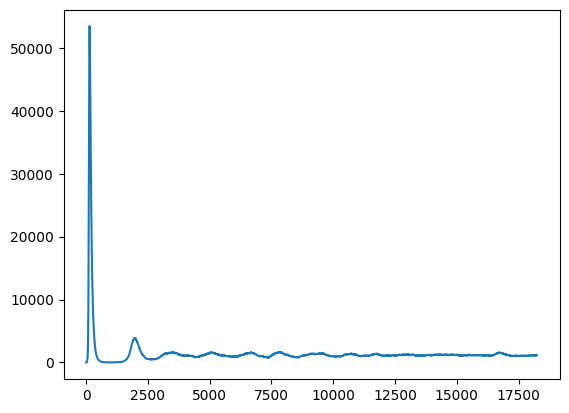

In [3]:
model = Model(scenario, parameters)
model.components = [
    Infect_Random_Agents,
    Births_ConstantPop,
    Susceptibility,
    Infection,
    Transmission,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times.

In [4]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
births = np.squeeze(model.patches.births)
pops = np.squeeze(model.patches.populations)[:-1]

print("S+I+R = N:  " + str(np.isclose(cases + susc + rec, pops).all()))

S+I+R = N:  True


### First scientific test check
As usual, we will test this on a single simulation instance and demonstrate the analysis, before moving on to testing over a range of input values.  
Here, we are interested in equilibrium behavior, so I first place a cut to exclude all infections that occur before day 10000. We then plot the data, an exponential distribution with the expected value of $\frac{1}{R_0 \mu}$, a best-fit exponential distribution to the data, and perform a KS test. 

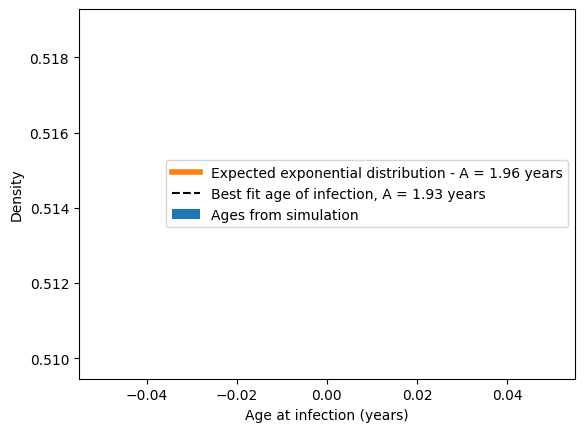

KstestResult(statistic=0.0026297177221289436, pvalue=0.7119393450505571, statistic_location=0.5698630136986301, statistic_sign=1)

In [5]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / (R0 * mu) / 365
a = np.arange(0, 15, 100)


def fit_age_at_infection(model, cutpos=10000):
    cut = model.population.doi > cutpos
    data = (model.population.doi[cut] - model.population.dob[cut]) / 365
    expfit = expon.fit(data)
    fitqual = kstest(data, expon.cdf, expfit)
    return data, expfit, fitqual


data, expfit, fitqual = fit_age_at_infection(model)


plt.hist(data, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Age at infection (years)")
plt.ylabel("Density")
plt.legend(
    [
        f"Expected exponential distribution - A = {A:.2f} years",
        f"Best fit age of infection, A = {expfit[1]:.2f} years",
        "Ages from simulation",
    ]
)
plt.show()
fitqual

### Second scientific test check
As noted above, because of the censoring that mortality induces, the distributions of age at infection vs. fraction susceptible at a given age will both follow exponential behavior but with a slight difference in the mean of the distribution - for the fraction susceptible, that value will be $\frac{1}{\mu (R_0-1)}$.  We develop this second test below. 

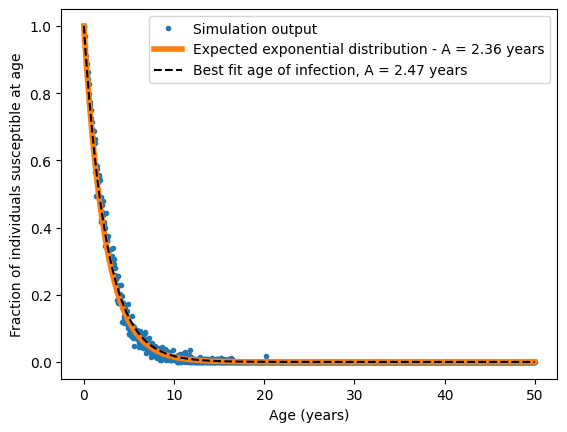

RMSE =  0.010549283479683653


In [6]:
A2 = 1 / ((R0 - 1) * mu) / 365


def Scurve(x, lam):
    return np.exp(-x / lam)


def fit_susceptibility_vs_age(model, cutpos=10000):
    cut = (model.population.susceptibility == 1) & (model.population.dob > cutpos)
    bins = np.linspace(0, 50, 1200)
    age_years = (np.max(model.population.dob) - model.population.dob) / 365
    n1 = np.histogram(age_years, bins=bins)[0]
    n2 = np.histogram(age_years[cut], bins=bins)[0]
    n1[n1 == 0] = 1
    y1 = n2 / n1
    popt, pcov = curve_fit(Scurve, bins[:-1] + np.mean(np.diff(bins)), y1, p0=2.5)
    mse = mean_squared_error(y1, Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, *popt))
    return y1, bins, popt, pcov, mse


data, bins, popt, pcov, mse = fit_susceptibility_vs_age(model)

# Plotting is a little more complicated here, want to plot at the bin centers and force y=1 at x=0
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *data], ".")
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *(Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, A2))], lw=4)
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *(Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, *popt))], "k--")
plt.legend(
    ["Simulation output", f"Expected exponential distribution - A = {A2:.2f} years", f"Best fit age of infection, A = {popt[0]:.2f} years"]
)
plt.xlabel("Age (years)")
plt.ylabel("Fraction of individuals susceptible at age")
plt.show()
print("RMSE = ", np.sqrt(mse))

### Third scientific test
As long as we are here, let's test that the age distribution of the population is correct.  With constant birth rate, equal to death rate, the population should have exponentially distributed ages with parameter $\frac{1}{\mu}$

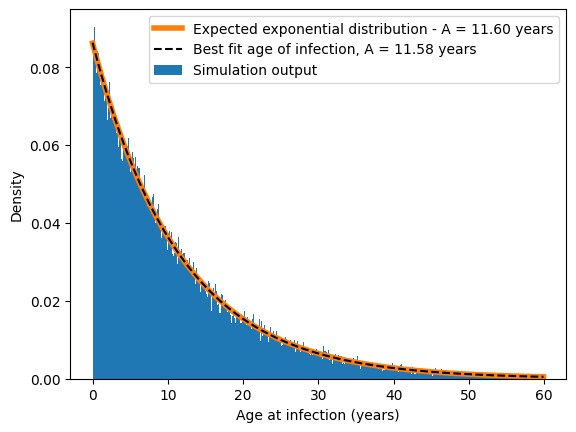

KstestResult(statistic=0.0030743868112242945, pvalue=0.3003816575133943, statistic_location=4.545205479452055, statistic_sign=-1)

In [7]:
# Test that population age distribution is correct
def fit_population_age_distribution(model):
    age_years = (np.max(model.population.dob) - model.population.dob) / 365
    expfit = expon.fit(age_years)
    fitqual = kstest(age_years, expon.cdf, expfit)
    return age_years, expfit, fitqual


age_years, expfit, fitqual = fit_population_age_distribution(model)
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
A = 1 / mu / 365
a = np.arange(0, 60, 0.1)

plt.hist(age_years, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Age at infection (years)")
plt.ylabel("Density")
plt.legend(
    [f"Expected exponential distribution - A = {A:.2f} years", f"Best fit age of infection, A = {expfit[1]:.2f} years", "Simulation output"]
)
plt.show()
fitqual


### Larger test suite
OK, so now we are going to replicate the above for many values of R0 and cbr, as a scientific validity test.

TODO: As written, this takes a long time.  That's because the space of random values being sampled occasionally produces models where the average age at infection is 30 years old, or so.  Correspondingly, those models take a long time to equilibrate so that the tests don't look terrible fail.  So as of right now, these run for 200 years to sidestep this.  Should instead restrict the range of values - higher cbrs and R0s - so that the average age at infection is consistently lower and we can get away with running for like 30-50 years instead.  

In [ ]:
%%capture

scenario = pd.DataFrame(data=[["homenode", 3e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])

cbrs = 15 + 85 * np.random.rand(25)
inf_means = 5 + 45 * np.random.rand(25)
R0s = 1.5 + 8.5 * np.random.rand(25)
output = pd.DataFrame(data={"cbr": cbrs, "inf_mean": inf_means, "R0": R0s})
output["Average_Iage_observed"] = np.nan
output["Average_Iage_expected"] = np.nan
output["Average_Sage_observed"] = np.nan
output["Average_Sage_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Average_age_expected"] = np.nan
for index, row in output.iterrows():
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 73000,
            "verbose": True,
            "beta": row["R0"] * (mu + 1 / row["inf_mean"]),
            "inf_mean": row["inf_mean"],
            "cbr": row["cbr"],
            "importation_period": 180,
            "importation_count": 3,
        }
    )

    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]
    set_initial_susceptibility_randomly(model, 1 / row["R0"] + 0.05)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
    _, expfit, _ = fit_age_at_infection(model, 36500)

    output.loc[index, "Average_Iage_expected"] = 1 / (row["R0"] * mu) / 365
    output.loc[index, "Average_Iage_observed"] = expfit[1]

    _, _, popt, _, _ = fit_susceptibility_vs_age(model, 36500)
    output.loc[index, "Average_Sage_expected"] = 1 / ((row["R0"] - 1) * mu) / 365
    output.loc[index, "Average_Sage_observed"] = popt[0]

    _, expfit, _ = fit_population_age_distribution(model)
    output.loc[index, "Average_age_expected"] = 1 / mu / 365
    output.loc[index, "Average_age_observed"] = expfit[1]

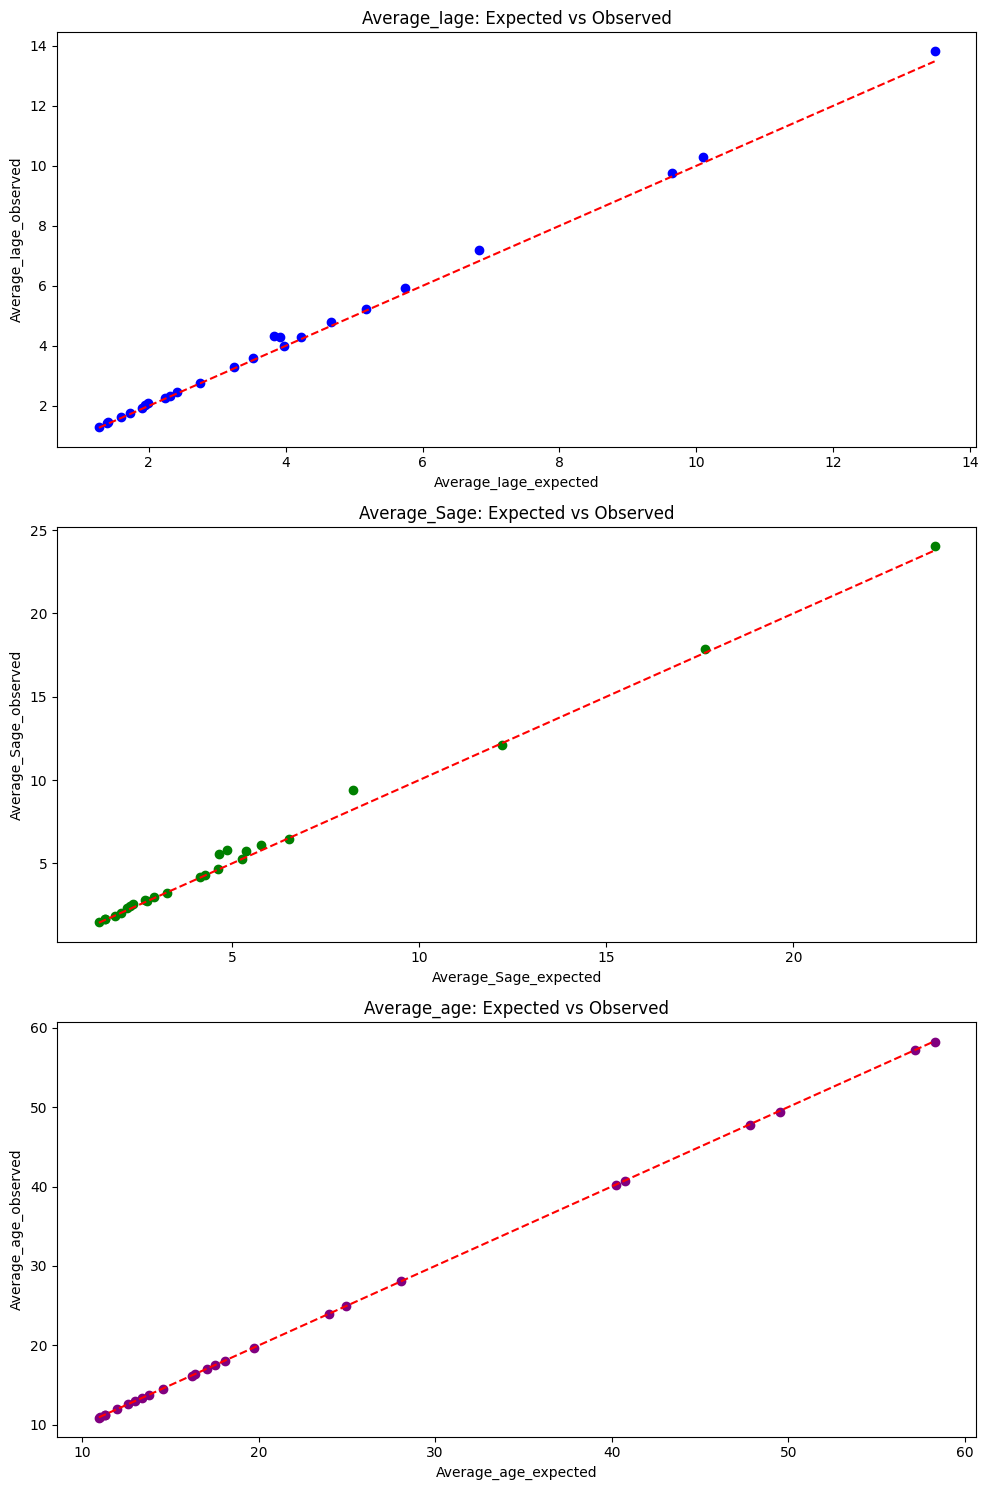

Average fractional deviation for Iage: 0.03001762383894115
Average fractional deviation for Sage: 0.046984990129488535
Average fractional deviation for age: 0.001878093793222975
Max deviation for Iage: 0.12833072279331145
Max deviation for Sage: 0.1990945702216195
Max deviation for age: 0.005183912555513777
Number of sims >5% away for Iage: 4
Number of sims >10% away for Iage: 1
Number of sims >5% away for Sage: 9
Number of sims >10% away for Sage: 3
Number of sims >5% away for age: 0
Number of sims >10% away for age: 0


Bad pipe message: %s [b'\xb4>\xd6I\x0bd\xa3\x9eC9\xd1\x9e#q\xd5\xb0R,\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00', b'\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007']
Bad pipe message: %s [b'\xa6I\xaa\xf9\xbf\xfaQ\x0b\xf9D\xe9\xe6\xe1O\x07*\xbc9\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xb

In [13]:
# Plotting the expected and observed values
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Average_Iage
axes[0].scatter(output["Average_Iage_expected"], output["Average_Iage_observed"], c="blue")
axes[0].plot(
    [output["Average_Iage_expected"].min(), output["Average_Iage_expected"].max()],
    [output["Average_Iage_expected"].min(), output["Average_Iage_expected"].max()],
    "r--",
)
axes[0].set_xlabel("Average_Iage_expected")
axes[0].set_ylabel("Average_Iage_observed")
axes[0].set_title("Average_Iage: Expected vs Observed")

# Plot for Average_Sage
axes[1].scatter(output["Average_Sage_expected"], output["Average_Sage_observed"], c="green")
axes[1].plot(
    [output["Average_Sage_expected"].min(), output["Average_Sage_expected"].max()],
    [output["Average_Sage_expected"].min(), output["Average_Sage_expected"].max()],
    "r--",
)
axes[1].set_xlabel("Average_Sage_expected")
axes[1].set_ylabel("Average_Sage_observed")
axes[1].set_title("Average_Sage: Expected vs Observed")

# Plot for Average_age
axes[2].scatter(output["Average_age_expected"], output["Average_age_observed"], c="purple")
axes[2].plot(
    [output["Average_age_expected"].min(), output["Average_age_expected"].max()],
    [output["Average_age_expected"].min(), output["Average_age_expected"].max()],
    "r--",
)
axes[2].set_xlabel("Average_age_expected")
axes[2].set_ylabel("Average_age_observed")
axes[2].set_title("Average_age: Expected vs Observed")

plt.tight_layout()
plt.show()

# Testing whether the expected and observed values are within 10% of each other
within_10_percent_Iage = np.abs(output["Average_Iage_expected"] - output["Average_Iage_observed"]) / output["Average_Iage_expected"] <= 0.1
within_10_percent_Sage = np.abs(output["Average_Sage_expected"] - output["Average_Sage_observed"]) / output["Average_Sage_expected"] <= 0.1
within_10_percent_age = np.abs(output["Average_age_expected"] - output["Average_age_observed"]) / output["Average_age_expected"] <= 0.1
# Calculate deviations
deviation_Iage = np.abs(output["Average_Iage_expected"] - output["Average_Iage_observed"]) / output["Average_Iage_expected"]
deviation_Sage = np.abs(output["Average_Sage_expected"] - output["Average_Sage_observed"]) / output["Average_Sage_expected"]
deviation_age = np.abs(output["Average_age_expected"] - output["Average_age_observed"]) / output["Average_age_expected"]

# Print average fractional deviation
print(f"Average fractional deviation for Iage: {deviation_Iage.mean()}")
print(f"Average fractional deviation for Sage: {deviation_Sage.mean()}")
print(f"Average fractional deviation for age: {deviation_age.mean()}")

# Print max deviation
print(f"Max deviation for Iage: {deviation_Iage.max()}")
print(f"Max deviation for Sage: {deviation_Sage.max()}")
print(f"Max deviation for age: {deviation_age.max()}")

# Print number of sims >5% and 10% away from expectation
print(f"Number of sims >5% away for Iage: {(deviation_Iage > 0.05).sum()}")
print(f"Number of sims >10% away for Iage: {(deviation_Iage > 0.1).sum()}")
print(f"Number of sims >5% away for Sage: {(deviation_Sage > 0.05).sum()}")
print(f"Number of sims >10% away for Sage: {(deviation_Sage > 0.1).sum()}")
print(f"Number of sims >5% away for age: {(deviation_age > 0.05).sum()}")
print(f"Number of sims >10% away for age: {(deviation_age > 0.1).sum()}")

In [10]:
output

,cbr,inf_mean,R0,Average_Iage_observed,Average_Iage_expected,Average_Sage_observed,Average_Sage_expected,Average_age_expected,Average_age_observed
0,63.554907,42.409730,1.682494,9.750279,9.645159,24.037127,23.777382,16.227922,16.189643
1,25.155963,12.290191,5.892347,7.201504,6.830650,9.421129,8.226841,40.248566,40.242902
2,82.675672,43.049260,5.637520,2.278314,2.232802,2.738516,2.714267,12.587468,12.581178
3,42.518917,23.703905,6.813700,3.586186,3.524385,4.204314,4.130606,24.014104,23.989177
4,24.828436,17.900917,8.751974,4.798632,4.658719,5.263876,5.259691,40.772986,40.721931
5,75.111987,30.283802,5.733280,2.455057,2.408054,2.976635,2.916804,13.806050,13.766623
6,58.767200,43.587196,6.366940,2.770982,2.750170,3.216703,3.262598,17.510166,17.497813
7,17.303534,24.492589,5.771713,10.290432,10.099057,12.120286,12.215500,58.288863,58.224728
8,62.836607,8.499595,8.269757,2.103711,1.984078,2.450275,2.257000,16.407842,16.401296
9,79.957752,17.927523,9.208948,1.454831,1.411543,1.667481,1.583495,12.998825,12.950422
